In [1]:
# importing relevant packages

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from eofs.standard import Eof

In [2]:
# loading in the datasets 
msl_ds = xr.open_dataset("msl_monthly.nc")
sst_ds = xr.open_dataset("sst_monthly.nc")
v10_ds = xr.open_dataset("v10_monthly.nc")
u10_ds = xr.open_dataset("u10_monthly.nc")

In [3]:
# turning datasets into numpy arrays - easier for manipulating 
msl = msl_ds.msl.to_numpy()
sst = sst_ds.sst.to_numpy()
v10 = v10_ds.v10.to_numpy()
u10 = u10_ds.u10.to_numpy()

### MSL DATA - for example and practise purposes

In [ ]:
# function to create bi-monthly seasons
# INPUT: data = xarray dataset
# OUTPUT: rolling mean values for adjacent timesteps
# from chatGPT: 
# for   Time steps:  [t1, t2, t3, t4]
#       Rolling mean: [(t1+t2)/2, (t2+t3)/2, (t3+t4)/2]
def create_bimonthly_seasons(data):
    return data.rolling(time=2, center=True).mean().dropna(dim='time')

In [109]:
# Subset the specified NS-EW region 
subset_msl_data = msl_ds.sel(latitude=slice(30, -30), longitude=slice(100, 290))
subset_msl_data         # view it to verify

bimonthly_msl_data = create_bimonthly_seasons(subset_msl_data)

# Step 1: Select the specific variable (assuming 'your_variable_name' is the name of your variable)
data_variable = bimonthly_msl_data['msl']  # Replace with your variable name

# Step 2: Stack spatial dimensions (lat, lon) into a single 'space' dimension
data_reshaped = data_variable.stack(space=('latitude', 'longitude')).transpose('time', 'space')

# Step 3: Handle missing or invalid values (if any)
data_masked = np.ma.masked_invalid(data_reshaped.values)

# Step 4: Perform EOF analysis
solver = Eof(data_masked)

# Step 5: Extract the first EOF (spatial pattern) and its time series (principal component)
eof1 = solver.eofs(neofs=1)  # First EOF (spatial pattern)
pc1 = solver.pcs(npcs=1)    # Principal Component (time series)

# Explained variance for the first EOF
variance_explained = solver.varianceFraction(neigs=1)

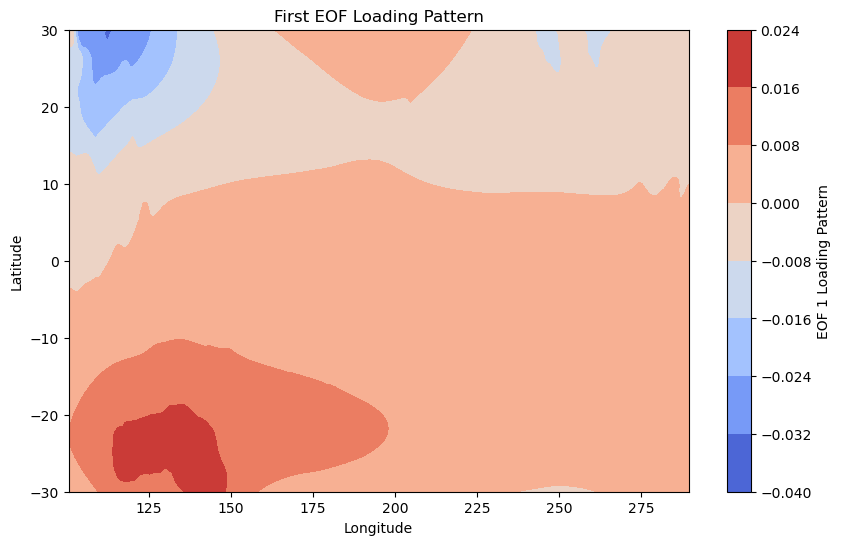

In [75]:
# Reshape EOF1 back to spatial dimensions for plotting
eof1_spatial = eof1[0].reshape((len(subset_msl_data['latitude']), len(subset_msl_data['longitude'])))

plt.figure(figsize=(10, 6))
plt.contourf(subset_msl_data['longitude'], subset_msl_data['latitude'], eof1_spatial, cmap='coolwarm')
plt.colorbar(label='EOF 1 Loading Pattern')
plt.title('First EOF Loading Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

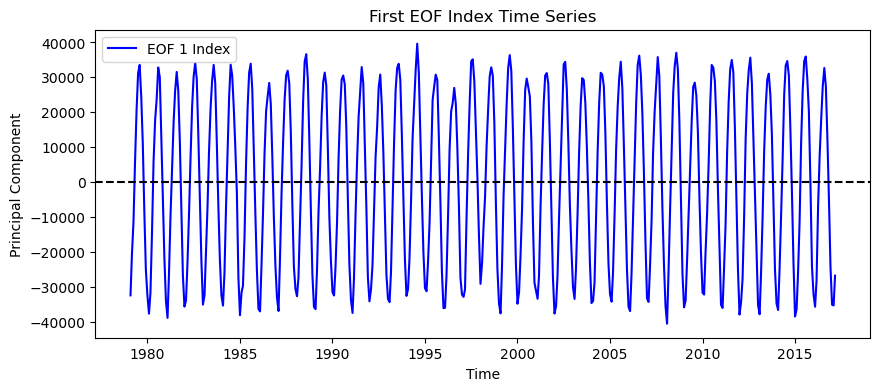

In [76]:
plt.figure(figsize=(10, 4))
plt.plot(bimonthly_msl_data['time'], pc1[:, 0], label='EOF 1 Index', color='b')
plt.axhline(0, color='k', linestyle='--')
plt.title('First EOF Index Time Series')
plt.xlabel('Time')
plt.ylabel('Principal Component')
plt.legend()
plt.show()

### Tidying the code into functions that will plot the data all together

In [157]:
# function to slice the relevant area and transform for rolling monthly seasons
# INPUT: ds = xarray dataset
# OUTPUT: seasons = xarray with rolling monthly averages
def reduce_data(ds):
    data_subset = ds.sel( latitude=slice(30, -30), longitude=slice(100, 290) )
    seasons = data_subset.rolling(time=2, center=True).mean().dropna(dim='time')
    return data_subset, seasons

In [155]:
# function to perform the EOF analysis for a given dataset
# INPUT:    var = string with relevant variable (msl, sst, u10 or v10)
#           data = bimonthly dataset
# OUTPUT: solver (Eof object)
def perform_EOF(var, data):
    # Step 1: Select the specific variable (assuming 'your_variable_name' is the name of your variable)
    data_variable = data[var]  # Replace with your variable name

    # Step 2: Stack spatial dimensions (lat, lon) into a single 'space' dimension
    data_reshaped = data_variable.stack(space=('latitude', 'longitude')).transpose('time', 'space')

    # Step 3: Handle missing or invalid values (if any)
    data_masked = np.ma.masked_invalid(data_reshaped.values)

    # Step 4: Perform EOF analysis
    solver = Eof(data_masked)

    return solver

In [169]:
# function to retrieve the EOF and make plots for each of the datasets
# OUTPUT: results = list containing the contour data to plot, currently of length 3 but will be length 4 when sst is figured out
def analyse(): 

    # store information to plot
    reduced_data = []
    bimonthlies = []
    contours = []
    PCs = []

    # perform EOF analysis for each of the 4 variables
    files = ["msl_monthly.nc",
             "sst_monthly.nc",
             "v10_monthly.nc",
             "u10_monthly.nc"]
    vars = ["msl", "sst", "v10", "u10"]

    for i in range(4):

        # skip sst for now
        if i !=1:

            print(f"\n\n working on {i}th dataset...") # message to track progress

            dataset = xr.open_dataset(files[i])
            subset, seasons = reduce_data(dataset)

            reduced_data.append(subset)     # save the smaller xarray datasets to use later when plotting
            bimonthlies.append(seasons)     

            solver = perform_EOF(vars[i], seasons)      # perform EOF analysis
        
            # Step 5: Extract the first EOF (spatial pattern) and its time series (principal component)
            eof1 = solver.eofs(neofs=1)  # First EOF (spatial pattern)
            pc1 = solver.pcs(npcs=1)    # Principal Component (time series)
            PCs.append(pc1)             # save the principal component
           
            # Explained variance for the first EOF (not sure if we need this)
            variance_explained = solver.varianceFraction(neigs=1)

            # Reshape EOF1 back to spatial dimensions for plotting, save to list
            eof1_spatial = eof1[0].reshape((len(seasons['latitude']), len(seasons['longitude'])))
            contours.append(eof1_spatial)
   
    return reduced_data, bimonthlies, contours, PCs

reduced_data, bimonthlies, contours, PCs = analyse()



 working on 0th dataset...


 working on 2th dataset...


 working on 3th dataset...


In [170]:
# function to plot the loading patterns (contour maps) of the EOF analyses
# INPUT: contours = list of information to be plotted, currently of length 3 but will be length 4 when sst is figured out
# TO DO: figure out how to get a colour map on there
def plot_loadingPatterns(contours):

    # prepare figure
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax=ax.ravel()

    # titles for the subplots
    names = ["Mean Sea Level Pressure",
            "Sea Surface Temperature",
            "10m Meridional Wind Speeds",
            "10m Zonal Wind Speeds "]
    
    # plot each of the contour maps
    for i in range(4):

        # ignoring sst for now 
        if i == 0:
            T = ax[i].contourf(reduced_data[i]['longitude'], reduced_data[i]['latitude'], contours[i], cmap='coolwarm')
        if i > 1:
            T = ax[i].contourf(reduced_data[i-1]['longitude'], reduced_data[i-1]['latitude'], contours[i-1], cmap='coolwarm')
        
        # ax[i].colorbar(label='EOF 1 Loading Pattern')
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        
    plt.suptitle("First EOF Loading Patterns")
    plt.show()

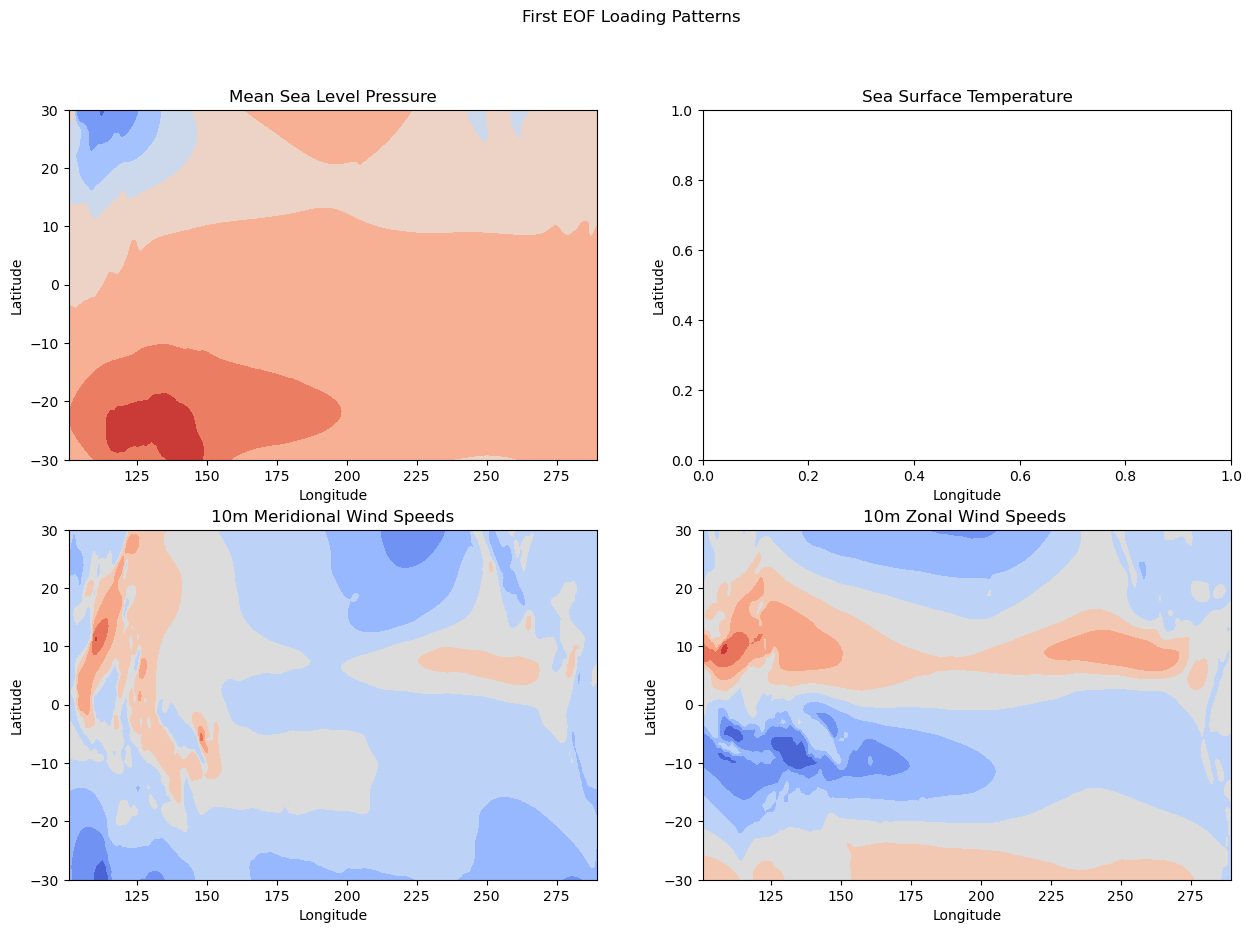

In [171]:
plot_loadingPatterns(contours)

In [ ]:
def plot_timeSeries(PCs):

    # prepare figure
    fig, ax = plt.subplots(2,2, figsize = (15,10))
    ax=ax.ravel()

    # titles for the subplots
    names = ["Mean Sea Level Pressure",
            "Sea Surface Temperature",
            "10m Meridional Wind Speeds",
            "10m Zonal Wind Speeds "]
    
    # plot each of the contour maps
    for i in range(4):

        # ignoring sst for now 
        if i == 0:
            T = ax[i].plot(bimonthlies[i]['time'], PCs[i][:, 0], label='EOF 1 Index', color='b')
        if i > 1:
            T = ax[i].plot(bimonthlies[i-1]['time'], PCs[i-1][:, 0], label='EOF 1 Index', color='b')
        
        ax[i].set_title(names[i])
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Principal Component')
        ax[i].axhline(0, color='k', linestyle='--')
        
    plt.suptitle("First EOF Index Time Series")
    plt.show()
    
# need to add a legend
# plt.legend()


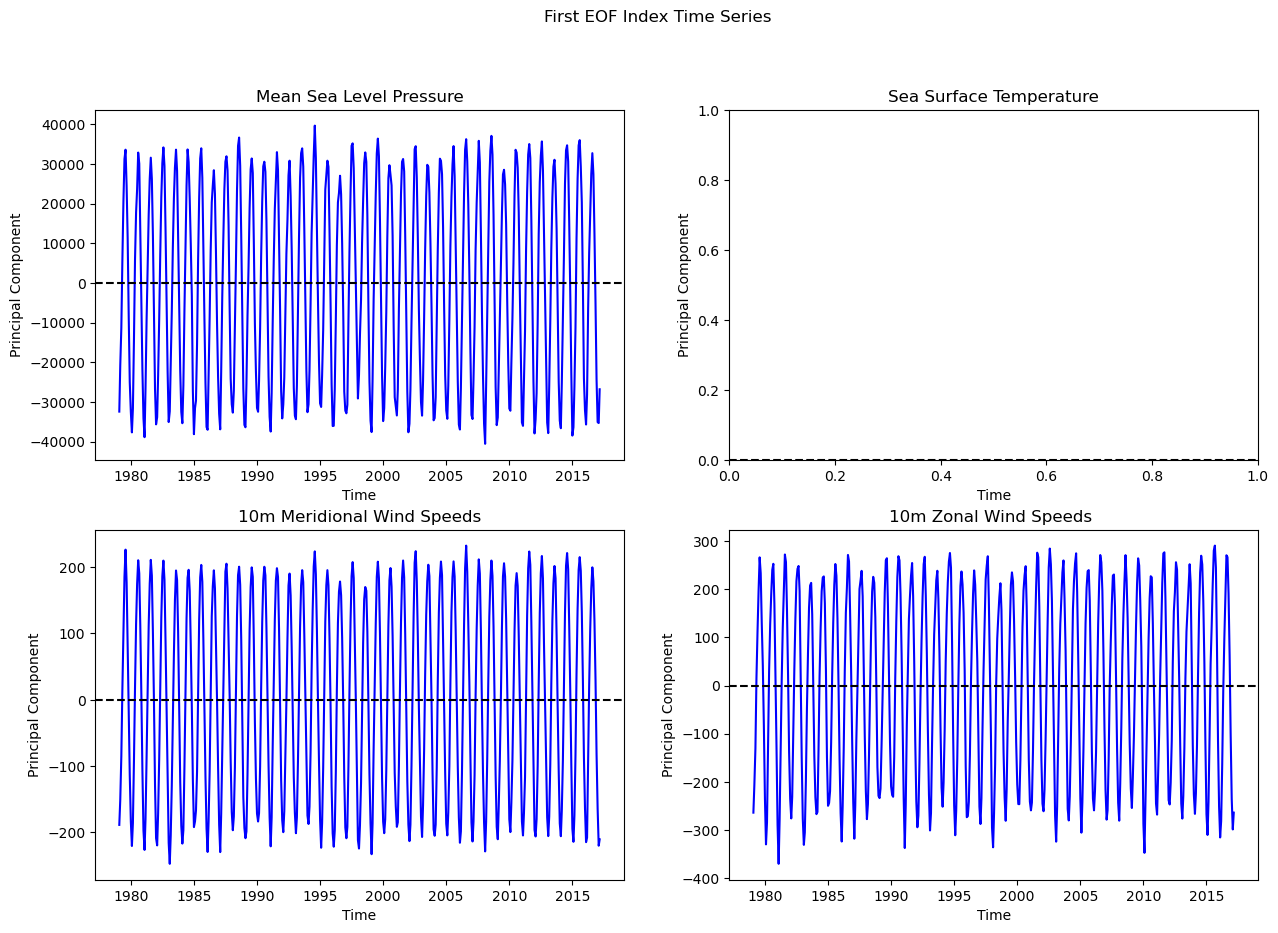

In [173]:
plot_timeSeries(PCs)

### SST DATA: practice code below bc the dataset doesn't work properly

In [ ]:
# Subset the specified NS-EW region 
subset_sst_data = sst_ds.sel(latitude=slice(30, -30), longitude=slice(100, 290))
# subset_sst_data         # view it to verify

bimonthly_sst_data = subset_sst_data.rolling(time=2, center=True).mean().dropna(dim='time')

# Step 1: Select the specific variable (assuming 'your_variable_name' is the name of your variable)
data_variable_sst = bimonthly_sst_data['sst']  # Replace with your variable name

# leaving the sst data here for now
time_missing = bimonthly_sst_data.isnull().mean(dim=('latitude', 'longitude'))


# Step 2: Stack spatial dimensions (lat, lon) into a single 'space' dimension
data_reshaped_sst = time_missing.stack(space=('latitude', 'longitude')).transpose('time', 'space')

# Step 3: Handle missing or invalid values (if any)
data_masked_sst = np.ma.masked_invalid(data_reshaped_sst.values)

# Step 4: Perform EOF analysis
solver_sst = Eof(data_masked_sst)

# Step 5: Extract the first EOF (spatial pattern) and its time series (principal component)
eof1_sst = solver_sst.eofs(neofs=1)  # First EOF (spatial pattern)
pc1_sst = solver_sst.pcs(npcs=1)    # Principal Component (time series)

# Explained variance for the first EOF
variance_explained_sst = solver_sst.varianceFraction(neigs=1)